# Sales Forecasting

Walmart has been having trouble figuring out how much to buy to restock its products and optimize sales. On the last important dates for the retail sector, the team had problems with purchasing supplies. In some departments, the purchase was above the expected sales and in others there was a lack of products.

The supply team asked us to help them solve their problem in forecasting demand for each store and each department. The team opted to build a regression model to predict sales and thus help the supply team scale purchases.

# 1.0 Data Catalog

**Dataset - Store**<br>
**Store** - Store IDs <br>
**Type** - Store types <br>
**Size** - Store sizes <br> <br>

**Dataset - Features**<br>
**Store** - Store IDs <br>
**Date** - The week <br>
**Temperature** - Average temperature in the region <br>
**Fuel Price** - Cost of fuel in region <br>
**MarkDown 1-5** - Anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA <br>
**CPI** - The customer price index <br>
**Unemployment** - The unemployment rate <br>
**IsHoliday** - Whether the week is a especial holiday week <br>
 <br>

**Dataset - Train/Test**<br>
**Store** - Store IDs <br>
**Dept** - Departament <br>
**Weekly_sales** - Weekly Sales <br>
**Date** - The first date of the week <br>
**IsHoliday** - True or False <br><br>


For convenience, the four holidays fall within the following weeks in the dataset (not all holidays are in the data):

**Super Bowl:**  <br>
    - 12-Feb-10 <br>
    - 11-Feb-11 <br>
    - 10-Feb-12 <br>
    - 8-Feb-13 <br>
**Labor Day:**  <br>
    - 10-Sep-10 <br>
    - 9-Sep-11 <br>
    - 7-Sep-12 <br>
    - 6-Sep-13 <br>
**Thanksgiving:**  <br>
    - 26-Nov-10 <br>
    - 25-Nov-11 <br>
    - 23-Nov-12 <br>
    - 29-Nov-13 <br>
**Christmas:**  <br>
    - 31-Dec-10 <br>
    - 30-Dec-11 <br>
    - 28-Dec-12 <br>
    - 27-Dec-13 <br>

# 2.0 Libraries

In [31]:
import pandas as pd
import pandasql as ps
import numpy as np



import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from IPython.display import Image

# 3.0 Loading Data

In [2]:
df_features = pd.read_csv('walmart-recruiting-store-sales-forecasting/features.csv')
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [3]:
df_stores = pd.read_csv('walmart-recruiting-store-sales-forecasting/stores.csv')
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [4]:
df_train_raw = pd.read_csv('walmart-recruiting-store-sales-forecasting/train.csv')
df_train_raw.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [5]:
df_test_raw = pd.read_csv('walmart-recruiting-store-sales-forecasting/test.csv')
df_test_raw.head()

,Store,Dept,Date,IsHoliday
0,1,1,2012-11-02,False
1,1,1,2012-11-09,False
2,1,1,2012-11-16,False
3,1,1,2012-11-23,True
4,1,1,2012-11-30,False


## 3.1 Join

In [6]:
query = """
    SELECT df.Store,
           df.Dept,
           df.Date,
           df.Weekly_Sales,
           df.IsHoliday,
           stores.Type,
           stores.Size,
           features.Temperature,
           features.Fuel_Price,
           features.MarkDown1,
           features.MarkDown2,
           features.MarkDown3,
           features.MarkDown4,
           features.MarkDown5,
           features.CPI,
           features.Unemployment
    FROM df_train_raw df
    LEFT JOIN df_stores stores
    ON stores.Store = df.Store 
    LEFT JOIN df_features features
    ON features.Store = df.Store AND features.Date = df.Date;
"""
df_train = ps.sqldf(query)

In [7]:
query = """
    SELECT df.Store,
           df.Dept,
           df.Date,
           df.IsHoliday,
           stores.Type,
           stores.Size,
           features.Temperature,
           features.Fuel_Price,
           features.MarkDown1,
           features.MarkDown2,
           features.MarkDown3,
           features.MarkDown4,
           features.MarkDown5,
           features.CPI,
           features.Unemployment
    FROM df_test_raw df
    LEFT JOIN df_stores stores
    ON stores.Store = df.Store 
    LEFT JOIN df_features features
    ON features.Store = df.Store AND features.Date = df.Date;
"""
df_test = ps.sqldf(query, locals())

# 4.0 Descriptive Analisys

In [8]:
df_train_desc = df_train.copy()
df_test_desc = df_test.copy()

We have missing value in MarkDown features

In [9]:
df_train_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         421570 non-null  int64  
 1   Dept          421570 non-null  int64  
 2   Date          421570 non-null  object 
 3   Weekly_Sales  421570 non-null  float64
 4   IsHoliday     421570 non-null  int64  
 5   Type          421570 non-null  object 
 6   Size          421570 non-null  int64  
 7   Temperature   421570 non-null  float64
 8   Fuel_Price    421570 non-null  float64
 9   MarkDown1     150681 non-null  float64
 10  MarkDown2     111248 non-null  float64
 11  MarkDown3     137091 non-null  float64
 12  MarkDown4     134967 non-null  float64
 13  MarkDown5     151432 non-null  float64
 14  CPI           421570 non-null  float64
 15  Unemployment  421570 non-null  float64
dtypes: float64(10), int64(4), object(2)
memory usage: 51.5+ MB


In [10]:
df_test_desc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 115064 entries, 0 to 115063
Data columns (total 15 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Store         115064 non-null  int64  
 1   Dept          115064 non-null  int64  
 2   Date          115064 non-null  object 
 3   IsHoliday     115064 non-null  int64  
 4   Type          115064 non-null  object 
 5   Size          115064 non-null  int64  
 6   Temperature   115064 non-null  float64
 7   Fuel_Price    115064 non-null  float64
 8   MarkDown1     114915 non-null  float64
 9   MarkDown2     86437 non-null   float64
 10  MarkDown3     105235 non-null  float64
 11  MarkDown4     102176 non-null  float64
 12  MarkDown5     115064 non-null  float64
 13  CPI           76902 non-null   float64
 14  Unemployment  76902 non-null   float64
dtypes: float64(9), int64(4), object(2)
memory usage: 13.2+ MB


In [13]:
# Unique Values
df_train_desc.nunique()

Store               45
Dept                81
Date               143
Weekly_Sales    359464
IsHoliday            2
Type                 3
Size                40
Temperature       3528
Fuel_Price         892
MarkDown1         2277
MarkDown2         1499
MarkDown3         1662
MarkDown4         1944
MarkDown5         2293
CPI               2145
Unemployment       349
dtype: int64

We already knew that Markdown columns had no data before 2011

In [14]:
# Missing Values
df_train_desc.isnull().sum().sort_values(ascending = False)

MarkDown2       310322
MarkDown4       286603
MarkDown3       284479
MarkDown1       270889
MarkDown5       270138
Store                0
Dept                 0
Date                 0
Weekly_Sales         0
IsHoliday            0
Type                 0
Size                 0
Temperature          0
Fuel_Price           0
CPI                  0
Unemployment         0
dtype: int64

### Numerical Features

IsHoliday feature has almost zero variance. Let's check futher to understand wether we should disregarding it

In [22]:
kurt = pd.DataFrame(df_train_desc.select_dtypes(include = ['int64', 'float64']).apply(lambda x: x.kurtosis())).T
skew = pd.DataFrame(df_train_desc.select_dtypes(include = ['int64', 'float64']).apply(lambda x: x.skew())).T
variance = pd.DataFrame(df_train_desc.select_dtypes(include = ['int64', 'float64']).var().round(2)).applymap(lambda x: "{:.{}f}".format(x, 2) if isinstance(x, (float)) else x).T
desc = pd.DataFrame(df_train_desc.describe())


df_stats = pd.concat([desc,  kurt, skew, variance]).T.reset_index()
df_stats.columns = ['atributos','count', 'mean', 'std','min', '25%', '50%', '75%', 'max', 'kurtosis', 'skew', 'variance']
df_stats

,atributos,count,mean,std,min,25%,50%,75%,max,kurtosis,skew,variance
0,Store,421570.0,22.200546,12.785297,1.0,11.0,22.0,33.0,45.0,-1.146503,0.077763,163.46
1,Dept,421570.0,44.260317,30.492054,1.0,18.0,37.0,74.0,99.0,-1.215571,0.358223,929.77
2,Weekly_Sales,421570.0,15981.258123,22711.183519,-4988.94,2079.65,7612.03,20205.8525,693099.36,21.49129,3.262008,515797856.84
3,IsHoliday,421570.0,0.070358,0.25575,0.0,0.0,0.0,0.0,1.0,9.288747,3.359867,0.07
4,Size,421570.0,136727.915739,60980.583328,34875.0,93638.0,140167.0,202505.0,219622.0,-1.206346,-0.32585,3718631543.04
5,Temperature,421570.0,60.090059,18.447931,-2.06,46.68,62.09,74.28,100.14,-0.635922,-0.321404,340.33
6,Fuel_Price,421570.0,3.361027,0.458515,2.472,2.933,3.452,3.738,4.468,-1.185405,-0.104901,0.21
7,MarkDown1,150681.0,7246.420196,8291.221345,0.27,2240.27,5347.45,9210.9,88646.76,17.606263,3.341845,68744351.40
8,MarkDown2,111248.0,3334.628621,9475.357325,-265.76,41.6,192.0,1926.94,104519.54,37.589561,5.441261,89782396.45
9,MarkDown3,137091.0,1439.421384,9623.07829,-29.1,5.08,24.6,103.99,141630.61,77.687772,8.399453,92603635.78


The stores have similar distribuition

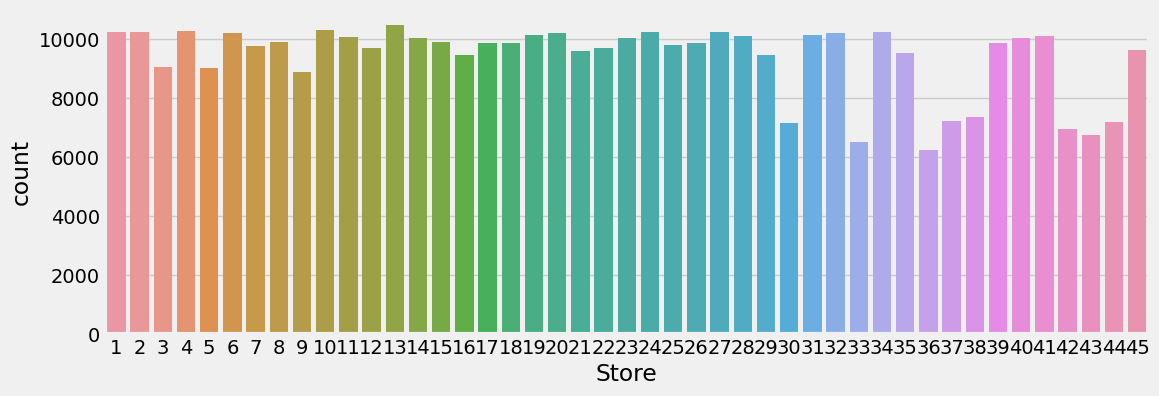

In [45]:
ax = sns.countplot(x = "Store", data = df_train_desc, orient = 'h')
ax.figure.set_size_inches(12, 4)

# 5.0 EDA (Exploratory Data Analysis)

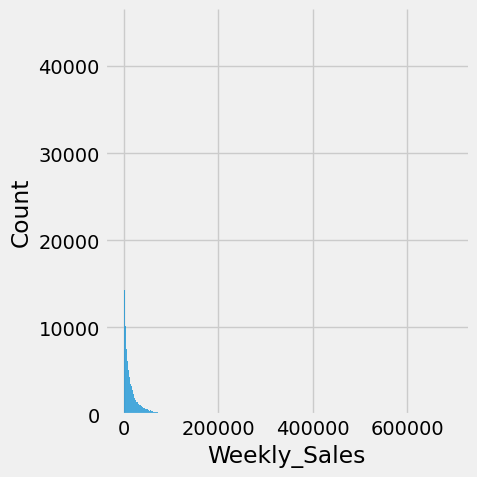

In [36]:
sns.displot(df_train_desc['Weekly_Sales'])
plt.show()

The data distribution is very similar on holidays and on normal days. But it is possible to notice that there are some days on holidays that sales skyrocketed.

[Text(0.5, 1.0, 'Boxplot Weekly_Sales'), Text(0.5, 0, 'Weekly_Sales')]

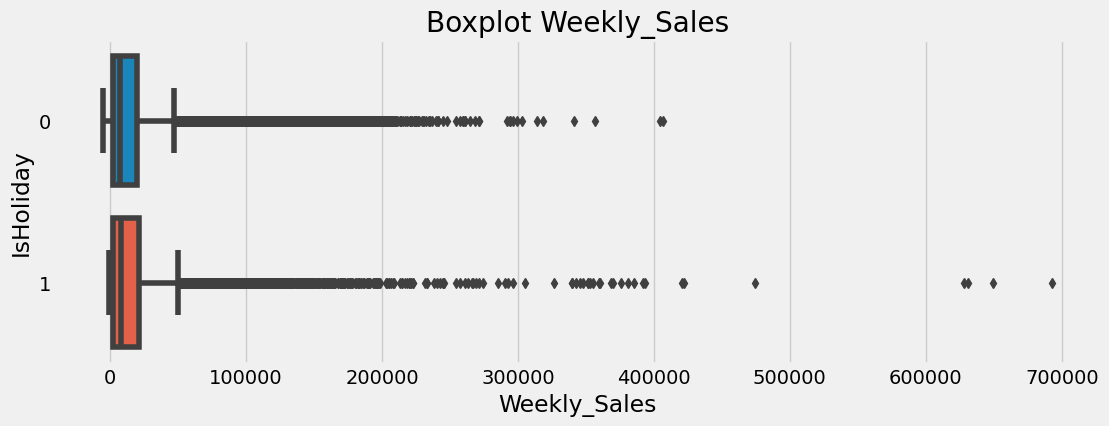

In [43]:
ax = sns.boxplot(x = "Weekly_Sales", y = 'IsHoliday', data = df_train_desc, orient = 'h')
ax.figure.set_size_inches(12,4)
ax.set(title = 'Boxplot Weekly_Sales', xlabel = 'Weekly_Sales')

# WIP